In [1]:
import parse_genet, simulate, test_simulation, mcmc_gtb
import os
import sys
import getopt
import vi
import importlib
import torch
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
import scipy.stats
import pandas as pd
import numpy as np
import pyro
from tqdm import tqdm

In [9]:
importlib.reload(vi)

<module 'vi' from '/gpfs/commons/home/daknowles/prscs/PRScs/vi.py'>

## loading data


### for the simulated 1000 SNPs from PRSCS, run this

In [3]:
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    'seed' : 42, 
    'beta_std' : "False", 
    'n_iter' : 1000,
    'chrom':22
}

### for chr22 data(wightman + ADSP bim file), run this instead

In [2]:
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : 'test_data/ADSP_qc_chr22',
    'sst_file' : 'test_data/wightman_chr22.tsv',
    'n_gwas' : 762971,
    'out_dir' : "test_data",
    'seed' : 42, 
    'beta_std' : "False", 
    'n_iter' : 1000,
    'chrom':22
}

### loading other data

In [4]:
importlib.reload(parse_genet)
chrom = param_dict['chrom']
ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')
ref_df = ref_df[ref_df.CHR == chrom]
vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
vld_df = vld_df[vld_df.CHR == chrom]
sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas']) ## take the interception SNP of sumstat, ref_ld, validate df
ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom) ## ld_blk & ld_blk_sym are the equal here.
print("There are %s ld_blocks. \n" %(len(ld_blk)))

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
Found 991 common SNPs in the reference, sumstats, and validation set 

... parse reference LD on chromosome 22 ...
There are 4 ld_blocks. 



# simulating data
## change variables in the following chuck for testing

```
anno_path(bool or string):  
    If no annotation wanted: anno_path = None (default)
    If easy annotations wanted (intercept, perfect_anno, random_anno): anno_path = False
    If specific annotation wanted, just leave the absolute path. (Could take multiple ones, seperate with ","): anno_path = path1,path2,....

noise_size(float):  How much noise to add to the perfect annotation. Could be set to zero.
run_prscs(bool): If you want to run PRSCS
refit_time(int): how many time to refit the same simulated data. (result will be saved every refit)
lr (float):Learning rate for the optimization
gaussian_anno_weight(bool): If false, 1/3 of anno_weight will be set to 0, other 2/3 will be dirichlet distributed 
path(string): Will save output here, but all the pics will be shown in the interactive mode
```

In [5]:
#path for our annotations:
bl_anno='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr'
deepsea='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/deepsea/deepsea_high_h2_chr'
enformer='/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/enformer/enformer_high_h2_chr'
all_anno = ','.join([bl_anno, deepsea, enformer])

## Change this accordingly
anno_path = False
noise_size = 0.1 
run_prscs = True 
refit_time = 1
phi_as_prior = False
lr = 0.03
constrain_sigma = True
gaussian_anno_weight = True 
path = 'test_output/' 


... simulating betas...
... simulating perfect anno...
... add noise between +- 0.1 for the perfect anno ...


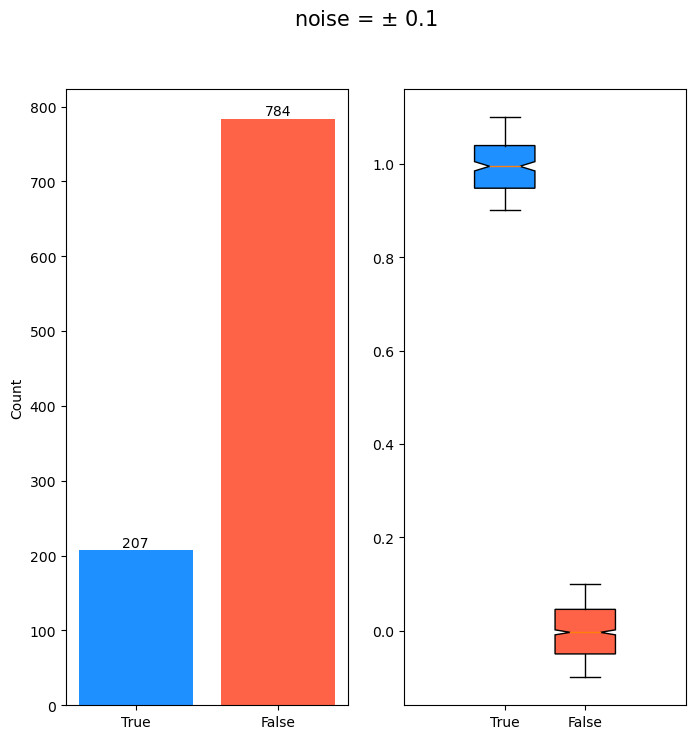

... start VI...


  0%|                                                                                                                                                                                     | 0/1 [00:00<?, ?it/s]

Re-train the model 1 time(s)
... Starting SVI ...
Degenerate LD mat (min eigenvalue=-4.230e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.784e-04), fixing to 1.000e-03
Done after 227 iterations. Increasing num_particles to 2.
Done after 93 iterations. Increasing num_particles to 4.


  0%|                                                                                                                                                                                     | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [15]:

importlib.reload(vi)
beta_true, beta_mrg, annotations, anno_names = simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], len(sst_dict), sst_dict, path, anno_path = anno_path, noise_size = noise_size, chrom=chrom)
sst_dict["BETA"] = beta_mrg

if anno_path != None:
    anno_names.insert(0,'intercept')    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("... start VI...")
plt.figure()
anno_list=pd.DataFrame()
betas = pd.DataFrame({'beta_true':beta_true, 'beta_marginal':beta_mrg})
for i in tqdm(range(refit_time)):
    print('Re-train the model %d time(s)'% (i+1))
    losses, beta, phi_est, stats =  vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, beta_prior_a = None, device = device, annotations = annotations, 
                                          max_iterations = param_dict['n_iter'], max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, 
                                          phi_as_prior = phi_as_prior, lr = lr, constrain_sigma = constrain_sigma, gaussian_anno_weight = gaussian_anno_weight, path = path)
    
    column_name = f'beta_casioPR_{i + 1}'
    betas[column_name] = beta
    plt.plot(losses);plt.title('losses')

    if anno_path != None:
        anno_df = pd.DataFrame.from_dict(stats["annotation_weights"])
        
        anno_list = pd.concat([anno_list, anno_df["mean"].to_frame().T], ignore_index=True)
    if i == refit_time-1:
        #plt.savefig(path+'loss.pdf',format ='pdf',bbox_inches='tight'); 
        plt.show()

if (run_prscs):
    beta_prscs = mcmc_gtb.mcmc(1, 0.5, None, sst_dict, param_dict['n_gwas'], ld_blk, blk_size, param_dict['n_iter'], 500, 5, int(chrom), path, False, 42)
    betas['beta_prscs'] = beta_prscs.flatten()

##  save beta
print('saving beta')
betas.to_csv(path+'betas.tsv', sep = '\t', index = False)


## get pearson, MSE, and mannwhitney U test 
beta_stats = test_simulation.get_beta_stats(betas)
beta_stats.to_csv(path+ '/betas_stat.tsv', sep = '\t', index = False)

##  plot pearson r between the marginal beta and betea of PRSCS/CasioPR 
test_simulation.plot_pearsonr(beta_stats, run_prscs, refit_time, path)

##  check anno_weight (only when annotation exist)
if anno_path != None: 
    anno_list.to_csv(path+'anno_weight.csv')
    plt.figure()
    plt.bar(anno_list.mean().index, anno_list.mean(), yerr=anno_list.std(), capsize=3, color='turquoise')
    plt.xticks(anno_list.mean().index, anno_names, rotation=90)
    plt.axhline(y = 0, linestyle = '--', color = 'darkgrey') 
    plt.ylabel('weight'); plt.title('iterate %d times'%(refit_time))
    #plt.savefig(path+'anno_weight.pdf',format ='pdf',bbox_inches='tight');
    plt.show()
    print('anno_weight')
    print(anno_list)


In [45]:
stats["sigma_noise"]

{'mean': tensor(0.9437),
 'std': tensor(0.0063),
 '5%': tensor(0.9329),
 '95%': tensor(0.9541)}

(array([-5.09156147e-04,  3.87082645e-03, -6.40650280e-03, -1.06926812e-02,
        -3.15171033e-02, -6.81131426e-03, -9.81961284e-03,  8.12481809e-03,
        -6.15836005e-04,  6.26982410e-06, -6.45177206e-04,  2.14900938e-03,
         2.32427032e-03,  1.18161272e-02,  3.62934521e-03, -7.00322026e-03,
         3.38353291e-02,  1.88209042e-02,  6.59218000e-04, -1.66703369e-02,
        -2.44330168e-02, -2.19718572e-02, -1.65288392e-02, -1.15555180e-02,
         2.46878285e-02, -1.58183649e-02, -1.95761379e-02,  1.46055780e-02,
         8.34128761e-04,  3.71906045e-03,  1.56797317e-03, -1.90060381e-02,
        -1.83648504e-02, -2.51102448e-02, -3.17542180e-02,  1.60594806e-02,
         2.57633738e-02, -1.39277158e-02, -2.55941395e-02, -1.25813317e-02,
        -8.32005346e-04,  2.97949999e-04, -1.21111600e-02, -5.73011301e-02,
         1.35840885e-02, -4.65595908e-02,  8.24374892e-03,  1.34090672e-03,
         5.72039448e-02,  3.46974768e-02, -1.42318150e-03, -5.51133044e-03,
        -2.3